In [1]:
import scanpy as sc
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding
import gdown
import os

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.5.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


# Load Fitness (SA609) Data

In [2]:
url = "https://drive.google.com/uc?id=1m_VkD-DBDuGj4MwncNEkm5f114vN6Dwf"
output = 'fitness.h5ad'
if not os.path.exists("fitness.h5ad"):
    gdown.download(url, output, quiet=False)
adata = sc.read("fitness.h5ad")
dataset = GeneVectorDataset(adata)

Downloading...
From: https://drive.google.com/uc?id=1m_VkD-DBDuGj4MwncNEkm5f114vN6Dwf
To: /Users/ceglian/Codebase/genevector/example/fitness.h5ad
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78.5M/78.5M [00:01<00:00, 61.3MB/s]


Loading Expression.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9479931/9479931 [01:32<00:00, 102749.95it/s]


Reindexing Cooc


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19799/19799 [00:02<00:00, 8384.51it/s]


In [3]:
retrain = False
if retrain:
    cmps = GeneVector(dataset,
                      output_file="fitness_X.vec",
                      batch_size=200000,
                      c=100.,
                      emb_dimension=100)
    cmps.train(100,threshold=1e-7)

# Load Embedding

In [4]:
embed = GeneEmbedding("embeddings/fitness_X.vec", dataset,vector="average")
print(embed.compute_similarities("ID1").head(20))

Loading average of 1st and 2nd weights.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3529073.62it/s]

        Gene  Similarity
0        ID1    1.000000
1        ID2    0.775131
2        ID4    0.753264
3        ID3    0.733372
4   HNRNPUL1    0.694974
5       TCF4    0.684364
6       SKA2    0.670993
7      NR2F2    0.666849
8      ZFHX3    0.655106
9       EGR1    0.642532
10    GAGE2A    0.635907
11     MSMO1    0.631988
12      H1F0    0.628049
13       FOS    0.619324
14     CDK14    0.617904
15     FOXP1    0.610703
16     TXNIP    0.605011
17     STAT3    0.596104
18      IER2    0.593848
19  KCNQ1OT1    0.592504


# Generate Metagenes

In [5]:
gdata = embed.get_adata(resolution=20)
metagenes = embed.get_metagenes(gdata)

computing neighbors


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 207 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


# Load Cell Embedding

In [6]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()

normalizing counts per cell
    finished (0:00:00)
Loading Expression.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19799/19799 [00:41<00:00, 479.27it/s]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


In [7]:
ct = []
for x in adata.obs["condition"]:
    if "T" in x:
        ct.append("Treated")
    else:
        ct.append("Untreated")
adata.obs["treatment"] = ct

/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
 

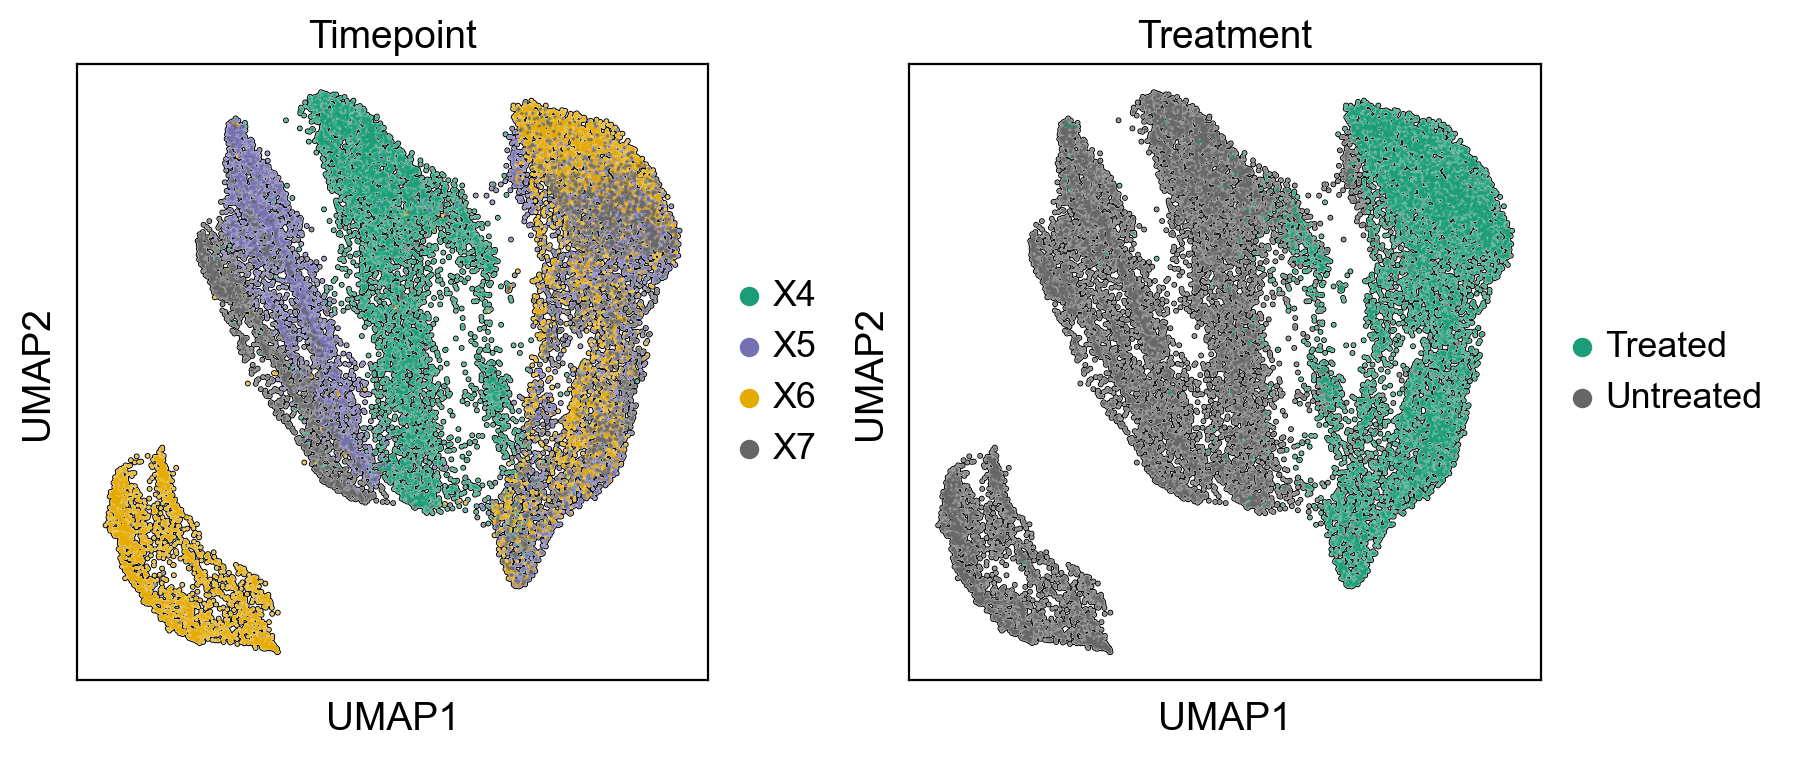

In [8]:
sc.pl.umap(adata, color=["timepoint","treatment"],palette="Dark2",
           wspace=0.2,title=["Timepoint","Treatment"], add_outline=True, save="treatment.pdf")

# Generate Metagenes and Look at Genes Similar to ID1 in Gene Embedding (cosine distance)

In [9]:
gdata = embed.get_adata(resolution=20)
metagenes = embed.get_metagenes(gdata)
for x,y in metagenes.items():
    if "ID1" in y:
        print(y)
    if "STAT3" in y:
        print(y)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 207 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
['ID3', 'ID2', 'EPCAM', 'KDM3A', 'FOXP1', 'HES1', 'ID4', 'PTN', 'BARX1', 'NCAM1', 'KCNMA1', 'ZFHX3', 'TCF4', 'ID1', 'SYCP2', 'SPINT2', 'H1F0']
['TCHH', 'IGFBP2', 'IGFBP5', 'TSPAN13', 'INSIG1', 'MAGEH1', 'SLC38A2', 'MEIS2', 'STAT3']


# Gene Module Scoring

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
for x in adata.obs.columns:
    if "SCORE" in x:
        del adata.obs[x]
embed.score_metagenes(adata, metagenes)

normalizing counts per cell
    finished (0:00:00)
computing score '161_SCORE'
    finished: added
    '161_SCORE', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score '74_SCORE'
    finished: added
    '74_SCORE', score of gene set (adata.obs).
    294 total control genes are used. (0:00:00)
computing score '75_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '75_SCORE', score of gene set (adata.obs).
    291 total control genes are used. (0:00:00)
computing score '94_SCORE'
    finished: added
    '94_SCORE', score of gene set (adata.obs).
    398 total control genes are used. (0:00:00)
computing score '80_SCORE'
    finished: added
    '80_SCORE', score of gene set (adata.obs).
    395 total control genes are used. (0:00:00)
computing score '85_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '85_SCORE', score of gene set (adata.obs).
    246 total control genes are used. (0:00:00)
computing score '96_SCORE'
    finished: added
    '96_SCORE', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score '133_SCORE'
    finished: added
    '133_SCORE', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score '12_SCORE'
    finished: added
    '12_SCORE', score of gene set (adata.obs).
    236 total control genes are used. (0:00:00)
computing score '57_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '57_SCORE', score of gene set (adata.obs).
    293 total control genes are used. (0:00:00)
computing score '145_SCORE'
    finished: added
    '145_SCORE', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score '6_SCORE'
    finished: added
    '6_SCORE', score of gene set (adata.obs).
    85 total control genes are used. (0:00:00)
computing score '92_SCORE'
    finished: added
    '92_SCORE', score of gene set (adata.obs).
    345 total control genes are used. (0:00:00)
computing score '7_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '7_SCORE', score of gene set (adata.obs).
    89 total control genes are used. (0:00:00)
computing score '76_SCORE'
    finished: added
    '76_SCORE', score of gene set (adata.obs).
    192 total control genes are used. (0:00:00)
computing score '24_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '24_SCORE', score of gene set (adata.obs).
    394 total control genes are used. (0:00:00)
computing score '100_SCORE'
    finished: added
    '100_SCORE', score of gene set (adata.obs).
    246 total control genes are used. (0:00:00)
computing score '14_SCORE'
    finished: added
    '14_SCORE', score of gene set (adata.obs).
    239 total control genes are used. (0:00:00)
computing score '32_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '32_SCORE', score of gene set (adata.obs).
    390 total control genes are used. (0:00:00)
computing score '10_SCORE'
    finished: added
    '10_SCORE', score of gene set (adata.obs).
    439 total control genes are used. (0:00:00)
computing score '124_SCORE'
    finished: added
    '124_SCORE', score of gene set (adata.obs).
    343 total control genes are used. (0:00:00)
computing score '20_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '20_SCORE', score of gene set (adata.obs).
    638 total control genes are used. (0:00:00)
computing score '13_SCORE'
    finished: added
    '13_SCORE', score of gene set (adata.obs).
    288 total control genes are used. (0:00:00)
computing score '125_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '125_SCORE', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score '9_SCORE'
    finished: added
    '9_SCORE', score of gene set (adata.obs).
    390 total control genes are used. (0:00:00)
computing score '93_SCORE'
    finished: added
    '93_SCORE', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score '43_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '43_SCORE', score of gene set (adata.obs).
    392 total control genes are used. (0:00:00)
computing score '56_SCORE'
    finished: added
    '56_SCORE', score of gene set (adata.obs).
    294 total control genes are used. (0:00:00)
computing score '78_SCORE'
    finished: added
    '78_SCORE', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score '21_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '21_SCORE', score of gene set (adata.obs).
    288 total control genes are used. (0:00:00)
computing score '81_SCORE'
    finished: added
    '81_SCORE', score of gene set (adata.obs).
    246 total control genes are used. (0:00:00)
computing score '197_SCORE'
    finished: added
    '197_SCORE', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score '40_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '40_SCORE', score of gene set (adata.obs).
    341 total control genes are used. (0:00:00)
computing score '184_SCORE'
    finished: added
    '184_SCORE', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score '36_SCORE'
    finished: added
    '36_SCORE', score of gene set (adata.obs).
    489 total control genes are used. (0:00:00)
computing score '41_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '41_SCORE', score of gene set (adata.obs).
    292 total control genes are used. (0:00:00)
computing score '77_SCORE'
    finished: added
    '77_SCORE', score of gene set (adata.obs).
    294 total control genes are used. (0:00:00)
computing score '88_SCORE'
    finished: added
    '88_SCORE', score of gene set (adata.obs).
    295 total control genes are used. (0:00:00)
computing score '48_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '48_SCORE', score of gene set (adata.obs).
    244 total control genes are used. (0:00:00)
computing score '68_SCORE'
    finished: added
    '68_SCORE', score of gene set (adata.obs).
    393 total control genes are used. (0:00:00)
computing score '127_SCORE'
    finished: added
    '127_SCORE', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score '29_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '29_SCORE', score of gene set (adata.obs).
    289 total control genes are used. (0:00:00)
computing score '5_SCORE'
    finished: added
    '5_SCORE', score of gene set (adata.obs).
    86 total control genes are used. (0:00:00)
computing score '50_SCORE'
    finished: added
    '50_SCORE', score of gene set (adata.obs).
    243 total control genes are used. (0:00:00)
computing score '70_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '70_SCORE', score of gene set (adata.obs).
    345 total control genes are used. (0:00:00)
computing score '199_SCORE'
    finished: added
    '199_SCORE', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score '46_SCORE'
    finished: added
    '46_SCORE', score of gene set (adata.obs).
    290 total control genes are used. (0:00:00)
computing score '119_SCORE'
    finished: added
    '119_SCORE', score of gene set (adata.obs).
    345 total control genes are used. (0:00:00)
computing score '19_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '19_SCORE', score of gene set (adata.obs).
    439 total control genes are used. (0:00:00)
computing score '15_SCORE'
    finished: added
    '15_SCORE', score of gene set (adata.obs).
    435 total control genes are used. (0:00:00)
computing score '114_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '114_SCORE', score of gene set (adata.obs).
    294 total control genes are used. (0:00:00)
computing score '105_SCORE'
    finished: added
    '105_SCORE', score of gene set (adata.obs).
    293 total control genes are used. (0:00:00)
computing score '82_SCORE'
    finished: added
    '82_SCORE', score of gene set (adata.obs).
    345 total control genes are used. (0:00:00)
computing score '165_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '165_SCORE', score of gene set (adata.obs).
    249 total control genes are used. (0:00:00)
computing score '194_SCORE'
    finished: added
    '194_SCORE', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score '60_SCORE'
    finished: added
    '60_SCORE', score of gene set (adata.obs).
    294 total control genes are used. (0:00:00)
computing score '95_SCORE'
    finished: added
    '95_SCORE', score of gene set (adata.obs).
    243 total control genes are used. (0:00:00)
computing score '47_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '47_SCORE', score of gene set (adata.obs).
    442 total control genes are used. (0:00:00)
computing score '99_SCORE'
    finished: added
    '99_SCORE', score of gene set (adata.obs).
    344 total control genes are used. (0:00:00)
computing score '90_SCORE'
    finished: added
    '90_SCORE', score of gene set (adata.obs).
    294 total control genes are used. (0:00:00)
computing score '196_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '196_SCORE', score of gene set (adata.obs).
    147 total control genes are used. (0:00:00)
computing score '37_SCORE'
    finished: added
    '37_SCORE', score of gene set (adata.obs).
    289 total control genes are used. (0:00:00)
computing score '26_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '26_SCORE', score of gene set (adata.obs).
    389 total control genes are used. (0:00:00)
computing score '16_SCORE'
    finished: added
    '16_SCORE', score of gene set (adata.obs).
    388 total control genes are used. (0:00:00)
computing score '38_SCORE'
    finished: added
    '38_SCORE', score of gene set (adata.obs).
    292 total control genes are used. (0:00:00)
computing score '25_SCORE'
    finished: added
    '25_SCORE', score of gene set (adata.obs).
    389 total control genes are used. (0:00:00)
computing score '8_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '8_SCORE', score of gene set (adata.obs).
    388 total control genes are used. (0:00:00)
computing score '39_SCORE'
    finished: added
    '39_SCORE', score of gene set (adata.obs).
    442 total control genes are used. (0:00:00)
computing score '83_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '83_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '176_SCORE'
    finished: added
    '176_SCORE', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score '112_SCORE'
    finished: added
    '112_SCORE', score of gene set (adata.obs).
    295 total control genes are used. (0:00:00)
computing score '131_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '131_SCORE', score of gene set (adata.obs).
    297 total control genes are used. (0:00:00)
computing score '135_SCORE'
    finished: added
    '135_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '111_SCORE'
    finished: added
    '111_SCORE', score of gene set (adata.obs).
    344 total control genes are used. (0:00:00)
computing score '101_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '101_SCORE', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score '2_SCORE'
    finished: added
    '2_SCORE', score of gene set (adata.obs).
    588 total control genes are used. (0:00:00)
computing score '146_SCORE'
    finished: added
    '146_SCORE', score of gene set (adata.obs).
    247 total control genes are used. (0:00:00)
computing score '117_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '117_SCORE', score of gene set (adata.obs).
    147 total control genes are used. (0:00:00)
computing score '69_SCORE'
    finished: added
    '69_SCORE', score of gene set (adata.obs).
    342 total control genes are used. (0:00:00)
computing score '98_SCORE'
    finished: added
    '98_SCORE', score of gene set (adata.obs).
    295 total control genes are used. (0:00:00)
computing score '84_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '84_SCORE', score of gene set (adata.obs).
    445 total control genes are used. (0:00:00)
computing score '65_SCORE'
    finished: added
    '65_SCORE', score of gene set (adata.obs).
    392 total control genes are used. (0:00:00)
computing score '45_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '45_SCORE', score of gene set (adata.obs).
    294 total control genes are used. (0:00:00)
computing score '168_SCORE'
    finished: added
    '168_SCORE', score of gene set (adata.obs).
    147 total control genes are used. (0:00:00)
computing score '1_SCORE'
    finished: added
    '1_SCORE', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score '4_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '4_SCORE', score of gene set (adata.obs).
    334 total control genes are used. (0:00:00)
computing score '0_SCORE'
    finished: added
    '0_SCORE', score of gene set (adata.obs).
    189 total control genes are used. (0:00:00)
computing score '142_SCORE'
    finished: added
    '142_SCORE', score of gene set (adata.obs).
    297 total control genes are used. (0:00:00)
computing score '23_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '23_SCORE', score of gene set (adata.obs).
    146 total control genes are used. (0:00:00)
computing score '179_SCORE'
    finished: added
    '179_SCORE', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score '102_SCORE'
    finished: added
    '102_SCORE', score of gene set (adata.obs).
    145 total control genes are used. (0:00:00)
computing score '18_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '18_SCORE', score of gene set (adata.obs).
    440 total control genes are used. (0:00:00)
computing score '31_SCORE'
    finished: added
    '31_SCORE', score of gene set (adata.obs).
    244 total control genes are used. (0:00:00)
computing score '64_SCORE'
    finished: added
    '64_SCORE', score of gene set (adata.obs).
    390 total control genes are used. (0:00:00)
computing score '110_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '110_SCORE', score of gene set (adata.obs).
    297 total control genes are used. (0:00:00)
computing score '3_SCORE'
    finished: added
    '3_SCORE', score of gene set (adata.obs).
    286 total control genes are used. (0:00:00)
computing score '122_SCORE'
    finished: added
    '122_SCORE', score of gene set (adata.obs).
    296 total control genes are used. (0:00:00)
computing score '140_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '140_SCORE', score of gene set (adata.obs).
    244 total control genes are used. (0:00:00)
computing score '188_SCORE'
    finished: added
    '188_SCORE', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score '63_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarnin

    finished: added
    '63_SCORE', score of gene set (adata.obs).
    294 total control genes are used. (0:00:00)
computing score '173_SCORE'
    finished: added
    '173_SCORE', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score '148_SCORE'
    finished: added
    '148_SCORE', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score '34_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '34_SCORE', score of gene set (adata.obs).
    289 total control genes are used. (0:00:00)
computing score '27_SCORE'
    finished: added
    '27_SCORE', score of gene set (adata.obs).
    91 total control genes are used. (0:00:00)
computing score '11_SCORE'
    finished: added
    '11_SCORE', score of gene set (adata.obs).
    535 total control genes are used. (0:00:00)
computing score '97_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '97_SCORE', score of gene set (adata.obs).
    145 total control genes are used. (0:00:00)
computing score '35_SCORE'
    finished: added
    '35_SCORE', score of gene set (adata.obs).
    92 total control genes are used. (0:00:00)
computing score '141_SCORE'
    finished: added
    '141_SCORE', score of gene set (adata.obs).
    346 total control genes are used. (0:00:00)
computing score '49_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '49_SCORE', score of gene set (adata.obs).
    441 total control genes are used. (0:00:00)
computing score '183_SCORE'
    finished: added
    '183_SCORE', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score '186_SCORE'
    finished: added
    '186_SCORE', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score '54_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '54_SCORE', score of gene set (adata.obs).
    342 total control genes are used. (0:00:00)
computing score '198_SCORE'
    finished: added
    '198_SCORE', score of gene set (adata.obs).
    97 total control genes are used. (0:00:00)
computing score '33_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '33_SCORE', score of gene set (adata.obs).
    290 total control genes are used. (0:00:00)
computing score '42_SCORE'
    finished: added
    '42_SCORE', score of gene set (adata.obs).
    393 total control genes are used. (0:00:00)
computing score '147_SCORE'
    finished: added
    '147_SCORE', score of gene set (adata.obs).
    244 total control genes are used. (0:00:00)
computing score '28_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '28_SCORE', score of gene set (adata.obs).
    490 total control genes are used. (0:00:00)
computing score '22_SCORE'
    finished: added
    '22_SCORE', score of gene set (adata.obs).
    290 total control genes are used. (0:00:00)
computing score '30_SCORE'
    finished: added
    '30_SCORE', score of gene set (adata.obs).
    389 total control genes are used. (0:00:00)
computing score '55_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '55_SCORE', score of gene set (adata.obs).
    391 total control genes are used. (0:00:00)
computing score '158_SCORE'
    finished: added
    '158_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '17_SCORE'
    finished: added
    '17_SCORE', score of gene set (adata.obs).
    90 total control genes are used. (0:00:00)
computing score '61_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '61_SCORE', score of gene set (adata.obs).
    392 total control genes are used. (0:00:00)
computing score '72_SCORE'
    finished: added
    '72_SCORE', score of gene set (adata.obs).
    295 total control genes are used. (0:00:00)
computing score '86_SCORE'
    finished: added
    '86_SCORE', score of gene set (adata.obs).
    292 total control genes are used. (0:00:00)
computing score '106_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '106_SCORE', score of gene set (adata.obs).
    297 total control genes are used. (0:00:00)
computing score '171_SCORE'
    finished: added
    '171_SCORE', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score '71_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '71_SCORE', score of gene set (adata.obs).
    392 total control genes are used. (0:00:00)
computing score '157_SCORE'
    finished: added
    '157_SCORE', score of gene set (adata.obs).
    246 total control genes are used. (0:00:00)
computing score '118_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '118_SCORE', score of gene set (adata.obs).
    296 total control genes are used. (0:00:00)
computing score '89_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    '89_SCORE', score of gene set (adata.obs).
    246 total control genes are used. (0:00:00)
computing score '177_SCORE'
    finished: added
    '177_SCORE', score of gene set (adata.obs).
    146 total control genes are used. (0:00:00)
computing score '52_SCORE'
    finished: added
    '52_SCORE', score of gene set (adata.obs).
    292 total control genes are used. (0:00:00)
computing score '178_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '178_SCORE', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score '159_SCORE'
    finished: added
    '159_SCORE', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score '62_SCORE'
    finished: added
    '62_SCORE', score of gene set (adata.obs).
    190 total control genes are used. (0:00:00)
computing score '103_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '103_SCORE', score of gene set (adata.obs).
    292 total control genes are used. (0:00:00)
computing score '113_SCORE'
    finished: added
    '113_SCORE', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score '155_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '155_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '144_SCORE'
    finished: added
    '144_SCORE', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score '189_SCORE'
    finished: added
    '189_SCORE', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score '153_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '153_SCORE', score of gene set (adata.obs).
    246 total control genes are used. (0:00:00)
computing score '108_SCORE'
    finished: added
    '108_SCORE', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score '138_SCORE'
    finished: added
    '138_SCORE', score of gene set (adata.obs).
    246 total control genes are used. (0:00:00)
computing score '79_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '79_SCORE', score of gene set (adata.obs).
    294 total control genes are used. (0:00:00)
computing score '91_SCORE'
    finished: added
    '91_SCORE', score of gene set (adata.obs).
    344 total control genes are used. (0:00:00)
computing score '185_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '185_SCORE', score of gene set (adata.obs).
    96 total control genes are used. (0:00:00)
computing score '172_SCORE'
    finished: added
    '172_SCORE', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score '59_SCORE'
    finished: added
    '59_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '190_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '190_SCORE', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score '67_SCORE'
    finished: added
    '67_SCORE', score of gene set (adata.obs).
    392 total control genes are used. (0:00:00)
computing score '201_SCORE'
    finished: added
    '201_SCORE', score of gene set (adata.obs).
    98 total control genes are used. (0:00:00)
computing score '134_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '134_SCORE', score of gene set (adata.obs).
    344 total control genes are used. (0:00:00)
computing score '107_SCORE'
    finished: added
    '107_SCORE', score of gene set (adata.obs).
    296 total control genes are used. (0:00:00)
computing score '44_SCORE'
    finished: added
    '44_SCORE', score of gene set (adata.obs).
    341 total control genes are used. (0:00:00)
computing score '121_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '121_SCORE', score of gene set (adata.obs).
    344 total control genes are used. (0:00:00)
computing score '160_SCORE'
    finished: added
    '160_SCORE', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score '154_SCORE'
    finished: added
    '154_SCORE', score of gene set (adata.obs).
    247 total control genes are used. (0:00:00)
computing score '51_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '51_SCORE', score of gene set (adata.obs).
    242 total control genes are used. (0:00:00)
computing score '66_SCORE'
    finished: added
    '66_SCORE', score of gene set (adata.obs).
    292 total control genes are used. (0:00:00)
computing score '73_SCORE'
    finished: added
    '73_SCORE', score of gene set (adata.obs).
    344 total control genes are used. (0:00:00)
computing score '151_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '151_SCORE', score of gene set (adata.obs).
    247 total control genes are used. (0:00:00)
computing score '195_SCORE'
    finished: added
    '195_SCORE', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)
computing score '163_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '163_SCORE', score of gene set (adata.obs).
    247 total control genes are used. (0:00:00)
computing score '128_SCORE'
    finished: added
    '128_SCORE', score of gene set (adata.obs).
    246 total control genes are used. (0:00:00)
computing score '152_SCORE'
    finished: added
    '152_SCORE', score of gene set (adata.obs).
    247 total control genes are used. (0:00:00)
computing score '53_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '53_SCORE', score of gene set (adata.obs).
    440 total control genes are used. (0:00:00)
computing score '139_SCORE'
    finished: added
    '139_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '58_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '58_SCORE', score of gene set (adata.obs).
    193 total control genes are used. (0:00:00)
computing score '115_SCORE'
    finished: added
    '115_SCORE', score of gene set (adata.obs).
    294 total control genes are used. (0:00:00)
computing score '137_SCORE'
    finished: added
    '137_SCORE', score of gene set (adata.obs).
    247 total control genes are used. (0:00:00)
computing score '167_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '167_SCORE', score of gene set (adata.obs).
    98 total control genes are used. (0:00:00)
computing score '120_SCORE'
    finished: added
    '120_SCORE', score of gene set (adata.obs).
    346 total control genes are used. (0:00:00)
computing score '162_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '162_SCORE', score of gene set (adata.obs).
    246 total control genes are used. (0:00:00)
computing score '156_SCORE'
    finished: added
    '156_SCORE', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score '132_SCORE'
    finished: added
    '132_SCORE', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score '187_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '187_SCORE', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score '129_SCORE'
    finished: added
    '129_SCORE', score of gene set (adata.obs).
    297 total control genes are used. (0:00:00)
computing score '104_SCORE'
    finished: added
    '104_SCORE', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score '150_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '150_SCORE', score of gene set (adata.obs).
    146 total control genes are used. (0:00:00)
computing score '182_SCORE'
    finished: added
    '182_SCORE', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score '174_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '174_SCORE', score of gene set (adata.obs).
    248 total control genes are used. (0:00:00)
computing score '87_SCORE'
    finished: added
    '87_SCORE', score of gene set (adata.obs).
    105 total control genes are used. (0:00:00)
computing score '116_SCORE'
    finished: added
    '116_SCORE', score of gene set (adata.obs).
    248 total control genes are used. (0:00:00)
computing score '126_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '126_SCORE', score of gene set (adata.obs).
    295 total control genes are used. (0:00:00)
computing score '166_SCORE'
    finished: added
    '166_SCORE', score of gene set (adata.obs).
    247 total control genes are used. (0:00:00)
computing score '170_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '170_SCORE', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score '123_SCORE'
    finished: added
    '123_SCORE', score of gene set (adata.obs).
    147 total control genes are used. (0:00:00)
computing score '109_SCORE'
    finished: added
    '109_SCORE', score of gene set (adata.obs).
    297 total control genes are used. (0:00:00)
computing score '203_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '203_SCORE', score of gene set (adata.obs).
    98 total control genes are used. (0:00:00)
computing score '149_SCORE'
    finished: added
    '149_SCORE', score of gene set (adata.obs).
    245 total control genes are used. (0:00:00)
computing score '191_SCORE'
    finished: added
    '191_SCORE', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

computing score '169_SCORE'
    finished: added
    '169_SCORE', score of gene set (adata.obs).
    247 total control genes are used. (0:00:00)
computing score '143_SCORE'
    finished: added
    '143_SCORE', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score '136_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '136_SCORE', score of gene set (adata.obs).
    294 total control genes are used. (0:00:00)
computing score '130_SCORE'
    finished: added
    '130_SCORE', score of gene set (adata.obs).
    146 total control genes are used. (0:00:00)
computing score '175_SCORE'
    finished: added
    '175_SCORE', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score '180_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '180_SCORE', score of gene set (adata.obs).
    147 total control genes are used. (0:00:00)
computing score '164_SCORE'
    finished: added
    '164_SCORE', score of gene set (adata.obs).
    247 total control genes are used. (0:00:00)
computing score '202_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceW

    finished: added
    '202_SCORE', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)
computing score '181_SCORE'
    finished: added
    '181_SCORE', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score '193_SCORE'
    finished: added
    '193_SCORE', score of gene set (adata.obs).
    147 total control genes are used. (0:00:00)
computing score '204_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '204_SCORE', score of gene set (adata.obs).
    98 total control genes are used. (0:00:00)
computing score '200_SCORE'
    finished: added
    '200_SCORE', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)
computing score '192_SCORE'
    finished: added
    '192_SCORE', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score '206_SCORE'


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

    finished: added
    '206_SCORE', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)
computing score '205_SCORE'
    finished: added
    '205_SCORE', score of gene set (adata.obs).
    49 total control genes are used. (0:00:00)


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

# Run OLS over Treated Timepoints for Scoring for Each Metagene

In [11]:
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import tqdm
import numpy
import pandas

t = adata[adata.obs["treatment"]=="Treated"]

t_slope = dict()
t_pvalues = dict()
clusters = []
order = ['UT', 'UTT', 'UTTT', 'UTTTT']
tps = [0,1,2,3]

for cluster, vector in metagenes.items():
    cluster = cluster + "_SCORE"
    values = []
    conditions = []
    ts = []
    for condition,tp in zip(order,tps):
        sub = t[t.obs["condition"]==condition]
        val = sub.obs[cluster].tolist()
        values += val
        ts += [tp for _ in val]
    df = pandas.DataFrame.from_dict({"condition":ts,"expression":values})    
    res = ols("expression ~ C(condition)", data=df).fit()
    t_pvalues[cluster] = res.summary2().tables[1]['P>|t|']["C(condition)[T.1]"]
    t_slope[cluster] = res.params['C(condition)[T.1]']

# Run again over Untreated Timepoints

In [12]:
u = adata[adata.obs["treatment"]=="Untreated"]

u_slope = dict()
u_pvalues = dict()
clusters = []
order = ['UU', 'UUU', 'UUUU', 'UUUUU']
tps = [0,1,2,3]

for cluster, vector in metagenes.items():
    cluster = cluster + "_SCORE"
    values = []
    conditions = []
    ts = []
    for condition,tp in zip(order,tps):
        sub = u[u.obs["condition"]==condition]
        val = sub.obs[cluster].tolist()
        values += val
        ts += [tp for _ in val]
    df = pandas.DataFrame.from_dict({"condition":ts,"expression":values})    
    res = ols("expression ~ C(condition)", data=df).fit()
    u_pvalues[cluster] = res.summary2().tables[1]['P>|t|']["C(condition)[T.1]"]
    u_slope[cluster] = res.params['C(condition)[T.1]']

# Load P-values and Coefficients in Data Frame

In [13]:
u_s = []
t_s = []
u_p = []
t_p = []
mgs = []
classt = []
for cluster in metagenes.keys():
    cluster = cluster + "_SCORE"
    t_s.append(t_slope[cluster])
    u_s.append(u_slope[cluster])
    u_p.append(t_pvalues[cluster])
    t_p.append(t_pvalues[cluster])
    mgs.append(cluster)
df = pandas.DataFrame.from_dict({"Metagene":mgs,
                                 "Untreated Coeff":u_s,
                                 "Treated Coeff":t_s,
                                 "Untreated pval":u_p,
                                 "Treated pval":t_p})
df

,Metagene,Untreated Coeff,Treated Coeff,Untreated pval,Treated pval
0,161_SCORE,-0.002152,0.064831,1.967194e-23,1.967194e-23
1,74_SCORE,-0.011169,0.046582,8.491938e-16,8.491938e-16
2,75_SCORE,-0.003817,0.031009,2.338066e-07,2.338066e-07
3,94_SCORE,-0.007520,0.023307,2.192270e-05,2.192270e-05
4,80_SCORE,-0.077618,-0.051414,9.332378e-14,9.332378e-14
...,...,...,...,...,...
202,204_SCORE,-0.005359,-0.043362,8.260804e-51,8.260804e-51
203,200_SCORE,-0.010367,0.006677,1.817127e-01,1.817127e-01
204,192_SCORE,0.001451,-0.010017,7.814258e-03,7.814258e-03
205,206_SCORE,0.000203,0.000888,3.091043e-01,3.091043e-01


In [14]:
increasing = []
for x,y in zip(df["Untreated Coeff"],df["Treated Coeff"]):
    if x < y and y > 0.1:
        increasing.append("Treatment Specific Metagenes")
    else:
        increasing.append("_Other")
df["label"] = increasing

hit -0.00910558111992673 0.16714718739902232 15
hit 0.012334542980268108 0.1404406177500989 72
hit 0.018177559673716297 0.20443561358155066 89
hit 0.01583092390207241 0.12603231662055353 98
hit 0.03190408473853101 0.17332064931090804 148


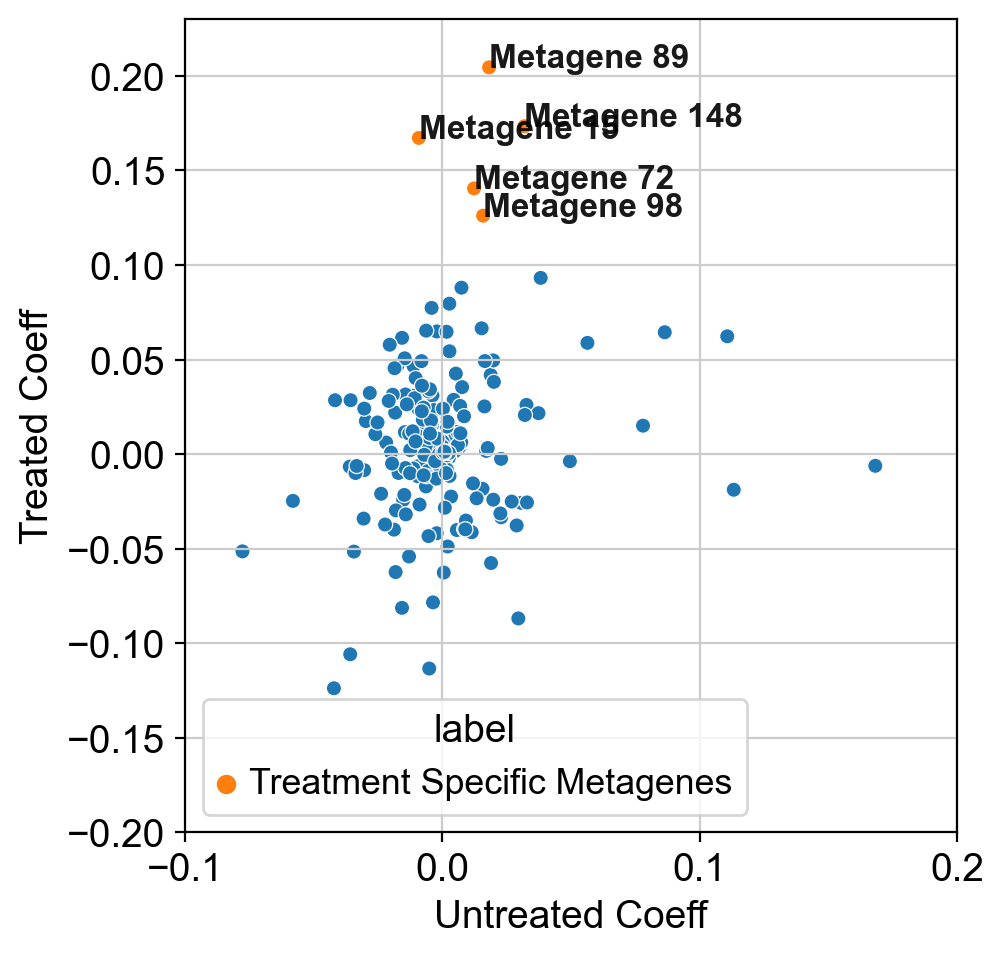

In [15]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax = sns.scatterplot(data=df,x="Untreated Coeff",y="Treated Coeff",s=30, hue="label",ax=ax)

for gene, x, y, l in zip(df.index,df["Untreated Coeff"],df["Treated Coeff"],df["label"]):
    if l != "_Other":
        print("hit",x,y, gene)
        ax.text(x, y, "Metagene "+str(gene), fontsize=12, alpha=0.9, fontweight="bold")
plt.tight_layout()


plt.xlim(-0.1,0.2)
plt.ylim(-0.2,0.23)
plt.savefig("/Users/ceglian/mgs_fit.pdf")

# Subset MGs that Increase in Treated with Significant Pvalue (Examine Untreated Coeff)

In [16]:
dfx = df[df["Treated pval"] < 0.001]
dfx = dfx[dfx["Treated Coeff"] > 0.1]
dfx = dfx[dfx["Untreated Coeff"] < dfx["Treated Coeff"]]
dfx = dfx.sort_values("Treated Coeff",ascending=False)
dfx

,Metagene,Untreated Coeff,Treated Coeff,Untreated pval,Treated pval,label
89,179_SCORE,0.018178,0.204436,4.406329e-251,4.406329e-251,Treatment Specific Metagenes
148,59_SCORE,0.031904,0.173321,4.112171e-208,4.112171e-208,Treatment Specific Metagenes
15,24_SCORE,-0.009106,0.167147,2.813565e-202,2.813565e-202,Treatment Specific Metagenes
72,135_SCORE,0.012335,0.140441,4.694332e-144,4.694332e-144,Treatment Specific Metagenes
98,188_SCORE,0.015831,0.126032,9.127745e-82,9.127745e-82,Treatment Specific Metagenes


# Look at only top 5 most increasing - Run GSEA with Hallmark Geneset

In [17]:
import gseapy as gp
import collections
enrc = collections.defaultdict(dict)
terms = set()
mgs = []
for mg in dfx["Metagene"]:
    if len( metagenes[mg.replace("_SCORE","")]) == 0: continue
    print(mg, metagenes[mg.replace("_SCORE","")])
    enr = gp.enrichr(gene_list=metagenes[mg.replace("_SCORE","")],
                     gene_sets=['MSigDB_Hallmark_2020'],
                     organism='Human', 
                     description='test_name',
                     outdir='test/enrichr_kegg',
                     cutoff=0.001 
                    )    
    mgs.append(mg)
    for x,y in zip(enr.res2d["Term"],enr.res2d["Combined Score"]):
        enrc[mg][x] = y
        terms.add(x)

179_SCORE ['CRABP2', 'KIF1A', 'GAGE13', 'CIB1']


/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-01-13 01:44:04,272 Warning: No enrich terms using library MSigDB_Hallmark_2020 when cutoff = 0.001


59_SCORE ['SPATS2L', 'TNIK', 'CPE', 'HSPA1A', 'TCAF1', 'VCX3A', 'VCX', 'FDFT1', 'SQLE', 'MYC', 'ZNF503', 'FOSB']


/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-01-13 01:44:05,661 Warning: No enrich terms using library MSigDB_Hallmark_2020 when cutoff = 0.001


24_SCORE ['ID3', 'ID2', 'EPCAM', 'KDM3A', 'FOXP1', 'HES1', 'ID4', 'PTN', 'BARX1', 'NCAM1', 'KCNMA1', 'ZFHX3', 'TCF4', 'ID1', 'SYCP2', 'SPINT2', 'H1F0']


/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


135_SCORE ['TXNIP', 'MSMO1', 'HMGCS1', 'TUBB2A', 'ARF5', 'GAGE2A', 'KCNQ1OT1']


/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-01-13 01:44:08,744 Warning: No enrich terms using library MSigDB_Hallmark_2020 when cutoff = 0.001


188_SCORE ['DNM3', 'LINC01118', 'BOC']


/Users/ceglian/miniconda3/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-01-13 01:44:10,103 Warning: No enrich terms using library MSigDB_Hallmark_2020 when cutoff = 0.001


In [18]:
mat = []
for term in terms:
    row = []
    for mg in mgs:
        if term in enrc[mg]:
            row.append(enrc[mg][term])
        else:
            row.append(0.0)
    mat.append(row)

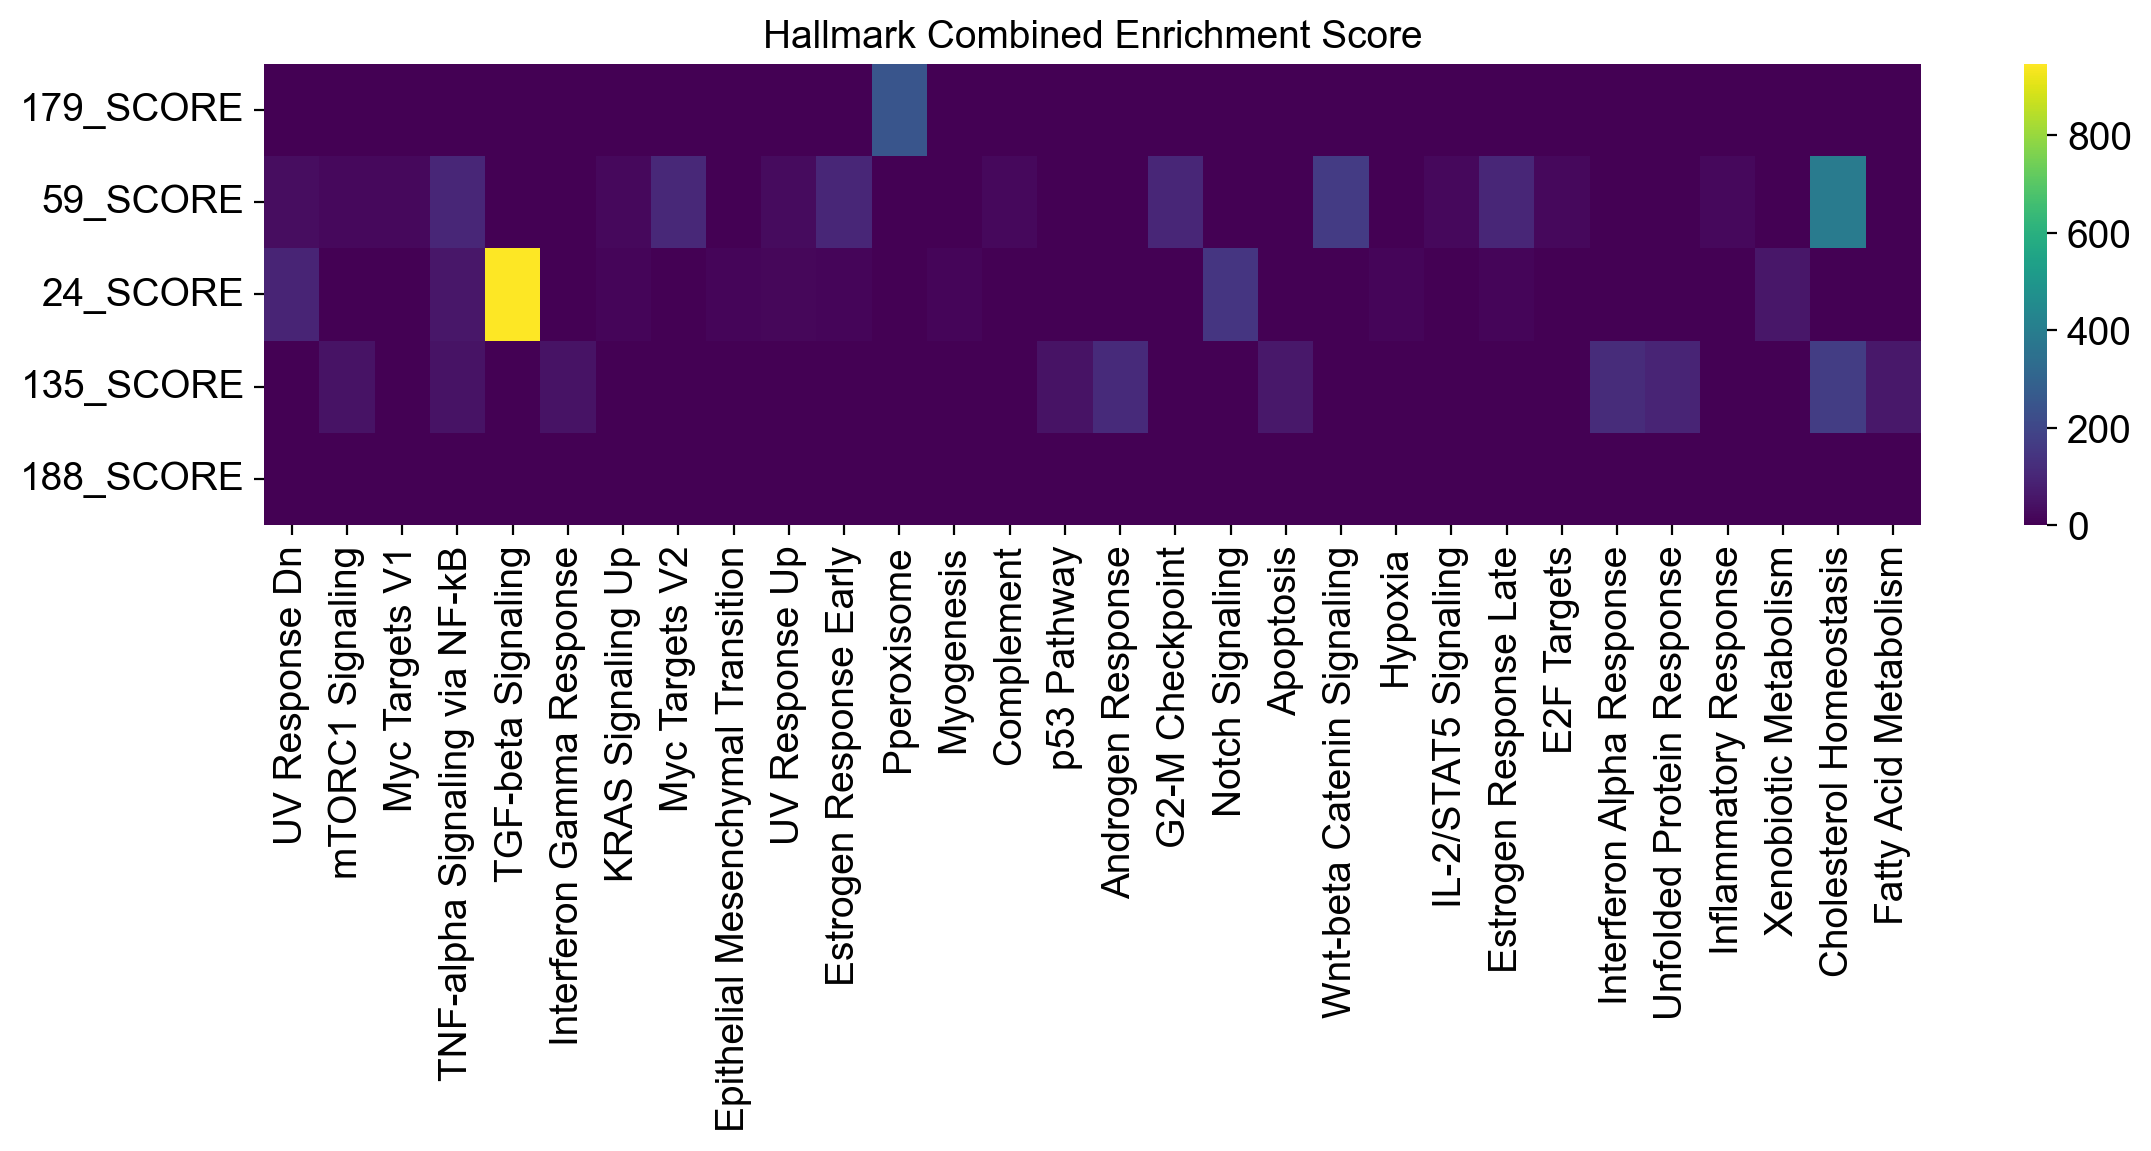

In [19]:
import seaborn as sns
df = pandas.DataFrame(numpy.array(mat),columns=mgs,index=list(terms)).T
fig, ax = plt.subplots(1,1,figsize=(12,6))
sns.heatmap(df,yticklabels=True,xticklabels=True,ax=ax,cmap="viridis")
ax.set_title("Hallmark Combined Enrichment Score")
fig.tight_layout()
plt.savefig("/Users/ceglian/treated.pdf")

# Most interesting Metagene 141

In [20]:
mgs_i = dict()
for mg in mgs:
    mg = mg.split("_")[0]
    mgs_i[mg] = metagenes[mg]

/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


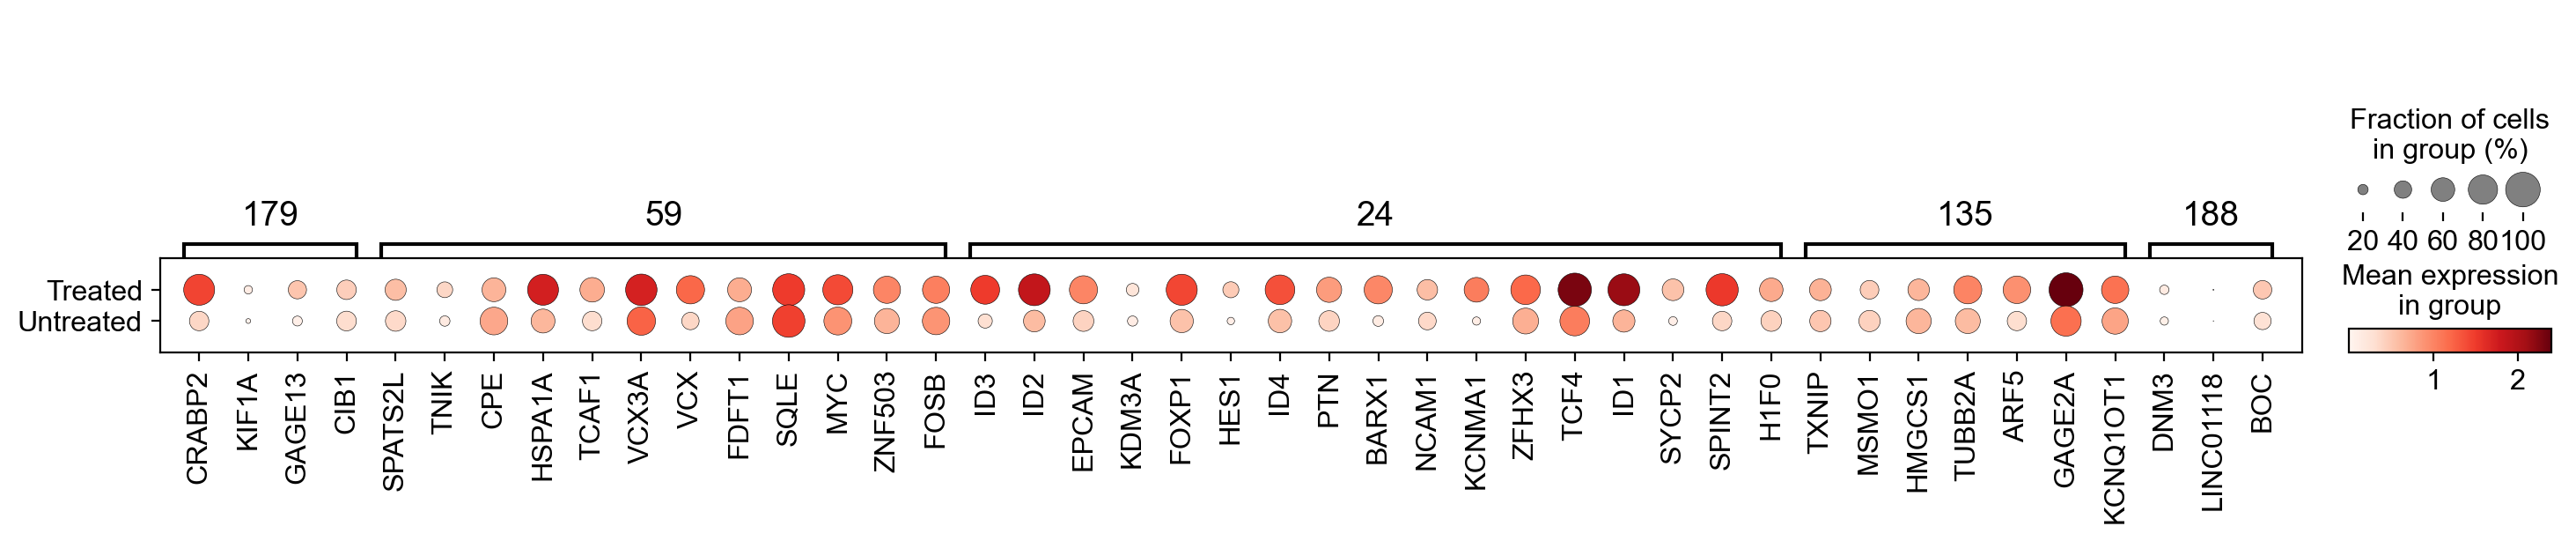

In [21]:
sc.pl.dotplot(adata,mgs_i,groupby="treatment")

In [22]:
tps = []
for x,y in zip(adata.obs["treatment"],adata.obs["timepoint"]):
    tps.append("{}_{}".format(x,y))
adata.obs["timepoint_treatment"] = tps

... storing 'timepoint_treatment' as categorical


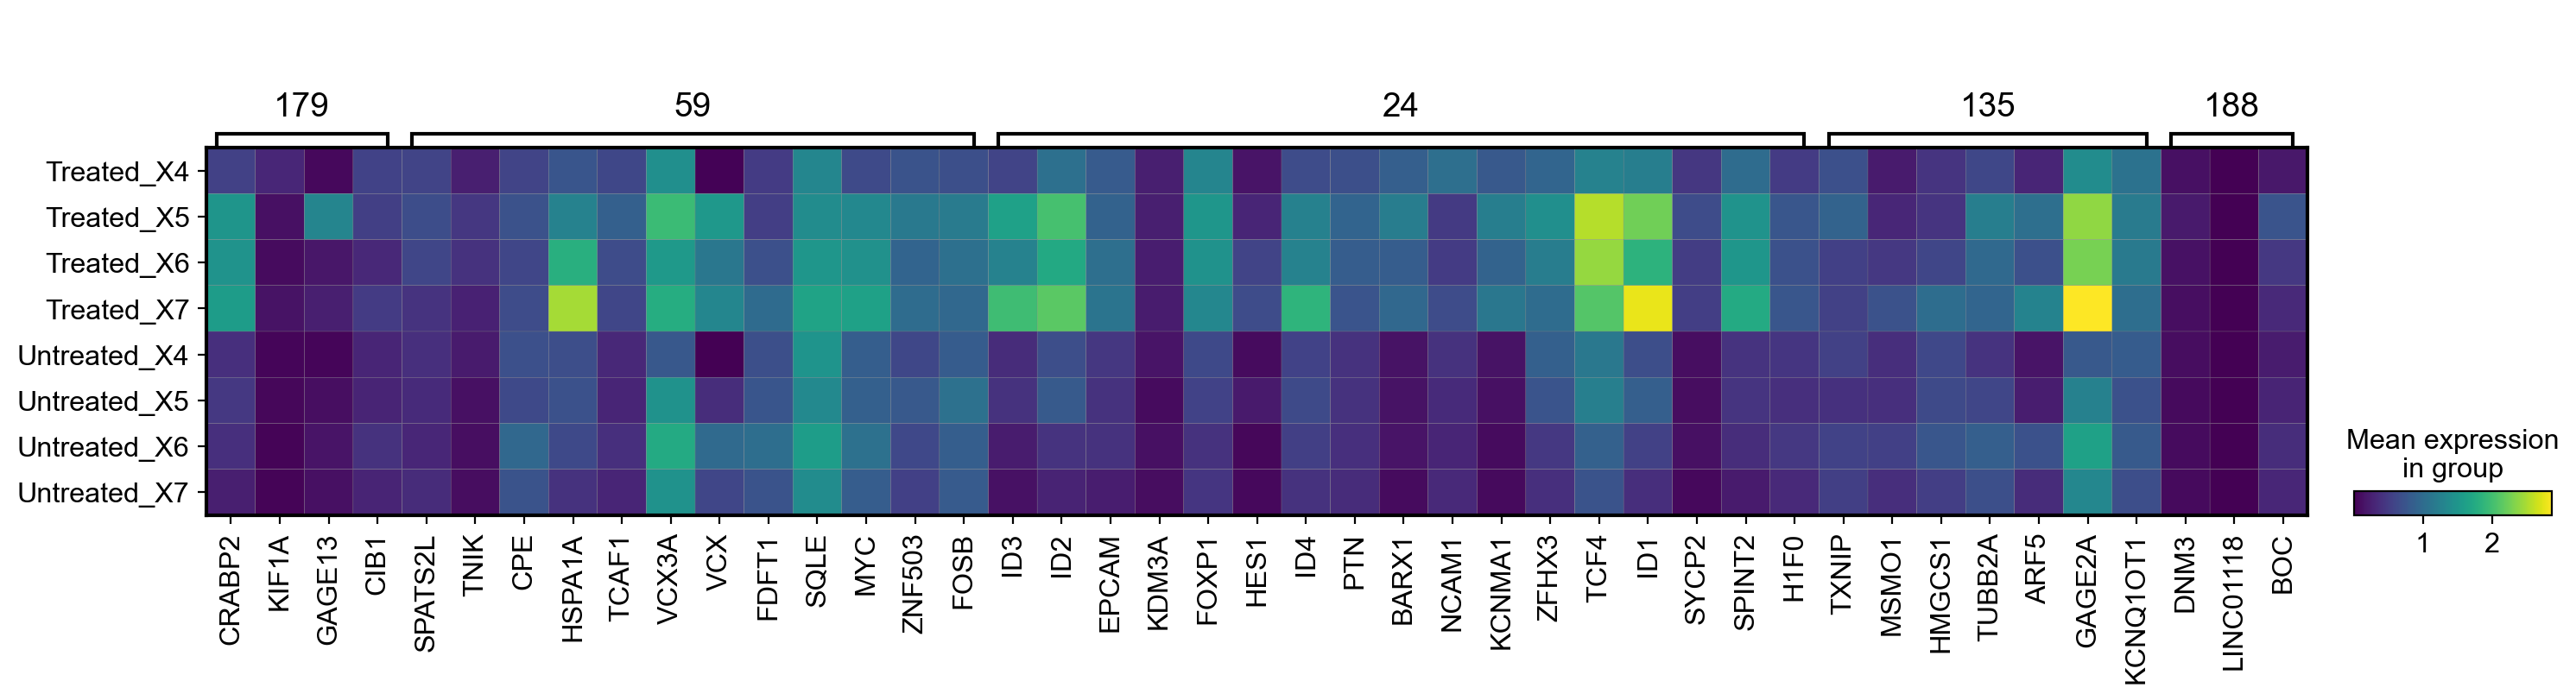

In [23]:
sc.pl.matrixplot(adata,mgs_i,groupby="timepoint_treatment",save="incr.pdf")

Untreated
Treated


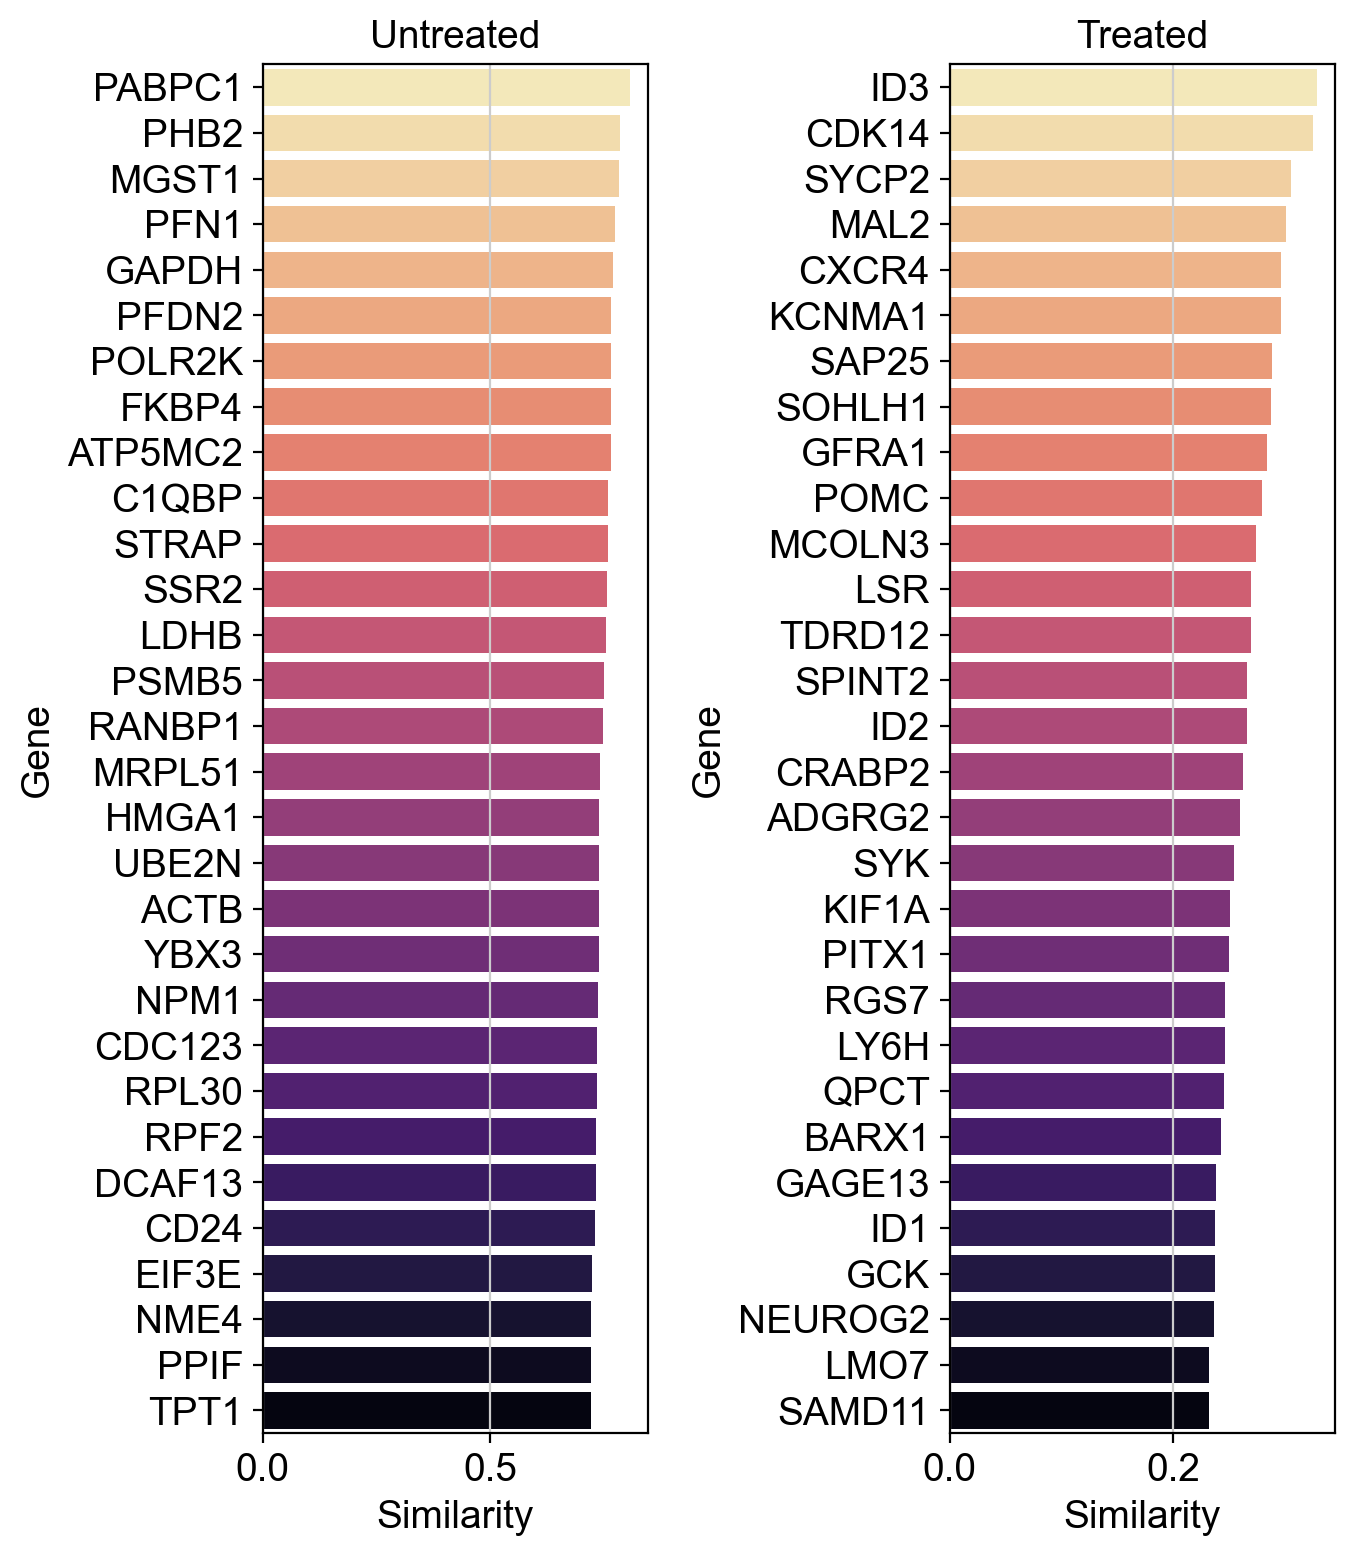

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

mapped_components = dict(zip(list(cembed.data.keys()),cembed.matrix))
comps = collections.defaultdict(list)
for bc,x in zip(adata.obs.index,adata.obs["treatment"]):
    comps[x].append(mapped_components[bc])
vectors = dict()
mean_vecs = []
for x, vec in comps.items():
    print(x)
    ovecs = []
    vec = numpy.mean(vec,axis=0)
    for oph, ovec in comps.items():
        for o in ovec:
            ovecs.append(o)
    aovec = numpy.average(ovecs,axis=0)
    vector = numpy.subtract(vec,aovec)
    vector = numpy.subtract(vector,cembed.dataset_vector)
    vectors[x] = vector
markers = dict()
fig,ax = plt.subplots(1,2,figsize=(7,8))
i = 0
for x, mvec in vectors.items():
    ct_sig = embed.get_similar_genes(mvec)[:30]
    sns.barplot(data=ct_sig,y="Gene",x="Similarity",palette="magma_r",ax=ax[i])
    ax[i].set_title(x)
    i += 1
fig.tight_layout()
plt.savefig("/Users/ceglian/treat.pdf")